# Training

*Creators: Lajos Bodo, Szilard Kosa*

Description: The program opens the dataset, preprocesses it, then trains the network.

In [1]:
# This library let's us work with hdf5 format files.
import tables
# Fundamental package for scientific computing with Python.
import numpy as np
# Used for printing the current progress only
from IPython.display import clear_output

# Setting the random seeds.
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

# Opening the dataset.
hdf5_path = "dataset.hdf5"
hdf5_file = tables.open_file(hdf5_path, mode='r')
print("Opening %s ."%(hdf5_path))

# Defining the number of pictures loaded for each person.
picture_per_person = 5

# Lists for storing the data from the dataset.
X = []
Y = []

# Defining variables needed for the algorithm.
data_num = hdf5_file.root.images.shape[0]
prev_label = hdf5_file.root.labels[0]
count = 0

# Reads the defined amount of pictures for each person.
for i in range(data_num):
    label = hdf5_file.root.labels[i]
    if i%1000 == 0:
        clear_output(wait=True)
        print("Loading: %.3f %%"%(float(i)/float(data_num-1)*100))
    if label != prev_label:
        count = 0

    if count < picture_per_person:
        X.append(hdf5_file.root.images[i])
        Y.append(label)
        count += 1
     
    prev_label = label

# Closing the file.
hdf5_file.close()
print()
print("HDF5 file closed.")

Loading: 99.898 %

HDF5 file closed.


## Splitting the dataset

In this cell we split the dataset into the training, the validation and the test parts.

In [2]:
# Defining the variables to split the dataset.
valid_split = 0.1
test_split = 0.1
# Calculating the splitting indexes.
nb_samples = len(Y)
valid_index = int(nb_samples*(1-valid_split-test_split)//picture_per_person)*picture_per_person
test_index = int(nb_samples*(1-test_split)//picture_per_person)*picture_per_person

# Splitting and standardizing the dataset.
X_train = [i/255 for i in X[0:valid_index]]
Y_train = [i/255 for i in Y[0:valid_index]]
X_valid = [i/255 for i in X[valid_index:test_index]]
Y_valid = [i/255 for i in Y[valid_index:test_index]]
X_test  = [i/255 for i in X[test_index:]]
Y_test  = [i/255 for i in Y[test_index:]]
print("Number of elements in X_train: %i" %(len(X_train)))
print("Number of elements in Y_train: %i" %(len(Y_train)))
print("Number of elements in X_valid: %i" %(len(X_valid)))
print("Number of elements in Y_valid: %i" %(len(Y_valid)))
print("Number of elements in X_test: %i" %(len(X_test)))
print("Number of elements in Y_test: %i" %(len(Y_test)))

Number of elements in X_train: 35580
Number of elements in Y_train: 35580
Number of elements in X_valid: 4445
Number of elements in Y_valid: 4445
Number of elements in X_test: 4450
Number of elements in Y_test: 4450


## Preproccessing training data

Here, we split the training data into the training batches.

In [3]:
X_train_batch = []
Y_train_batch = []
# Defining the number of persons included in a batch.
person_per_batch = 10
# Calculating the number of pictures in a batch.
picture_per_batch = picture_per_person*person_per_batch
# Calculating number of batches.
batch_number = int(len(Y_train)//picture_per_batch)
print("The number of batches used in training: {}".format(batch_number))
for i in range(batch_number):
    X_train_batch.append(X_train[i*picture_per_batch:(i+1)*picture_per_batch])
    Y_train_batch.append(Y_train[i*picture_per_batch:(i+1)*picture_per_batch])

The number of batches used in training: 711


## Preproccessing validation data 

Here, we split the validation data into the validation batches.

In [4]:
X_valid_batch = []
Y_valid_batch = []
# Calculating number of batches.
batch_number = int(len(Y_valid)//picture_per_batch)
print("The number of batches used in validation: {}".format(batch_number))
for i in range(batch_number):
    X_valid_batch.append(X_valid[i*picture_per_batch:(i+1)*picture_per_batch])
    Y_valid_batch.append(Y_valid[i*picture_per_batch:(i+1)*picture_per_batch])

The number of batches used in validation: 88


## Preproccessing test data 

Creating lists for the test data. The positives will contain pairs from the same person. The negatives will contain pairs from two different persons.

In [5]:
X_test_positives = []
Y_test_positives = []
X_test_negatives = []
Y_test_negatives = []

# The test data is cut in half annd loaded into the lists defined above.
half_index_test = int((0.5*len(X_test)//picture_per_person)*picture_per_person)
X_test_positives = X_test[0:half_index_test]
Y_test_positives = Y_test[0:half_index_test]
print("Number of elements in X_test_positives: %i" %(len(X_test_positives)))
print("Number of elements in Y_test_positives: %i" %(len(Y_test_positives)))

# The negatives list is made with the following technique:
# In the first half of the list, to every second place we insert a random element from the second half.
# This way every two following pictures are from different persons.
half_index_test_negatives = half_index_test + int((0.5*len(Y_test[half_index_test:])//picture_per_person)*picture_per_person)
x_test_negatives = X_test[half_index_test:half_index_test_negatives]
y_test_negatives = Y_test[half_index_test:half_index_test_negatives]
randperm = np.random.permutation(len(Y_test[half_index_test_negatives:]))
for i in range(int(len(x_test_negatives)/picture_per_person)):
    for j in range(picture_per_person):
        X_test_negatives.append(x_test_negatives[i*picture_per_person+j])
        X_test_negatives.append(X_test[randperm[i*picture_per_person+j]+half_index_test_negatives])
        Y_test_negatives.append(y_test_negatives[i*picture_per_person+j])
        Y_test_negatives.append(Y_test[randperm[i*picture_per_person+j]+half_index_test_negatives])
print("Number of elements in X_test_negatives: %i" %(len(X_test_negatives)))
print("Number of elements in Y_test_negatives: %i" %(len(Y_test_negatives)))

Number of elements in X_test_positives: 2225
Number of elements in Y_test_positives: 2225
Number of elements in X_test_negatives: 2220
Number of elements in Y_test_negatives: 2220


## Training

Importing the necessary parts from keras.

In [6]:
import keras
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Lambda
from keras.models import Model

Using TensorFlow backend.


Due to the lack of high-level implementation of triplet loss training method we create a simple model to test our solution. Because of the simplicity of this model it's not the most suitable for this task. Future improvements are needed.

In [7]:
# First, define the vision modules
digit_input = Input(shape=(64, 64, 1))
x = Conv2D(64, (3, 3))(digit_input)
x = Conv2D(64, (3, 3))(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3))(x)
x = Conv2D(64, (3, 3))(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
out = Dense(128, activation='relu')(x)
norm_layer = Lambda(lambda  x: keras.backend.l2_normalize(x,axis=1))(out)

vision_model = Model(digit_input, norm_layer)

With the previously defined model we create a model with three inputs. It was done with Keras functional api.

In [8]:
# Then define the tell-digits-apart model
in_a = Input(shape=(64, 64, 1))
in_p = Input(shape=(64, 64, 1))
in_n = Input(shape=(64, 64, 1))

# The vision model will be shared, weights and all
out_a = vision_model(in_a)
out_p = vision_model(in_p)
out_n = vision_model(in_n)

concatenated = keras.layers.concatenate([out_a, out_p, out_n])

model = Model([in_a, in_p, in_n], concatenated)

In [9]:
vision_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
__________

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          1496000     input_2[0][0]                    
                                                                 input_3[0][0]                    
          

The following function is a custom loss function based on the one used at https://thelonenutblog.wordpress.com/2018/02/13/how-to-potty-train-a-siamese-network/
It's been modified to match the one mentioned in the FaceNet paper.

In [11]:
import keras.backend as K
def triplet_loss(y_true, y_pred, alpha = 0.4):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """

    anchor = y_pred[:,:128]
    positive = y_pred[:,128:256]
    negative = y_pred[:,256:]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

Compiling the model with Adam optimiser and with triplet_loss function defined above.

In [12]:
from keras import optimizers

adam = optimizers.Adam(0.0001)

model.compile(optimizer=adam,
                  loss=triplet_loss)

The triplets are generated during training with the following generator. It generates only hard, and semi-hard triplets from the training batches. It can be also used to generate triplets for validation, when the for_training parameter is set to False.

In [13]:
# for generating the combinations
import itertools

# defining a triplet loss function, that uses numpy for calculations
def tripletloss(anchor, positive, negative, alpha = 0.4):
    # distance between the anchor and the positive
    pos_dist = np.sum(np.square(anchor-positive))

    # distance between the anchor and the negative
    neg_dist = np.sum(np.square(anchor-negative))

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = np.maximum(basic_loss,0.0)
 
    return loss

def triplet_generator(network, X, for_training = True):
    while True:
        # interating through the batches
        for index in range(len(X)):
            # creating lists to store the images and the predictions
            preds = []
            imgs = []
            # storing picture_per_batch amount of pictures
            for i in range(picture_per_batch):
                # dimension expansion
                img = np.expand_dims(X[index][i], axis=0)
                img = np.expand_dims(img, axis=3)
                imgs.append(img)
                preds.append(network.predict([img,img,img])[0][0:128])
            # creating all of the possible picture combinations per person
            duos = []
            img_duos = []
            for i in range(person_per_batch):
                for duo in itertools.combinations(imgs[i*picture_per_person:(i+1)*picture_per_person],2):
                    img_duos.append(duo)
                for duo in itertools.combinations(preds[i*picture_per_person:(i+1)*picture_per_person],2):
                    duos.append(duo)
            # creating the triplets
            triplets = []
            img_triplets = []
            # interating through every person
            for i in range(person_per_batch):
                # the number of picture combinations per person
                dn = int(len(duos)/person_per_batch)
                # iterating through all the combinations, and finding the right triplets
                for j in range(dn):
                    ind = dn*i+j
                    iter = 0
                    found = False
                    # Iterating through the whole batch to find a hard or a semi-hard negative.
                    # If none of them is suitable, then that combination is discarded.
                    while iter<picture_per_batch and not found:
                        if for_training:
                            if iter not in range(i*picture_per_person,(i+1)*picture_per_person) and tripletloss(duos[ind][0],duos[ind][1],preds[iter]) > 0:
                                triplets.append([duos[ind][0],duos[ind][1],preds[iter]])
                                img_triplets.append([img_duos[ind][0],img_duos[ind][1],imgs[iter]])
                                found = True
                        # if it is for validation then it is not necessary to find a hard or semi-hard negítive
                        else:
                            if iter not in range(i*picture_per_person,(i+1)*picture_per_person):
                                triplets.append([duos[ind][0],duos[ind][1],preds[iter]])
                                img_triplets.append([img_duos[ind][0],img_duos[ind][1],imgs[iter]])
                                found = True
                        iter += 1
            # transforming the results into the shape the model expects
            batch_size = len(img_triplets)
            batch1 = np.zeros((batch_size,64,64,1))
            batch2 = np.zeros((batch_size,64,64,1))
            batch3 = np.zeros((batch_size,64,64,1))
            for b in range(batch_size):
                batch1[b] = img_triplets[b][0][0,...]
                batch2[b] = img_triplets[b][1][0,...]
                batch3[b] = img_triplets[b][2][0,...]
            batch_x = [batch1,batch2,batch3]
            batch_y = np.zeros(batch_size)
            yield( batch_x, batch_y )

Displaying the first batch of triplets generated by the triplet_generator.

SHAPE OF THE BATCH: (100, 64, 64, 1)
1th Triplets of 100:
Positive distance: 0.23816022276878357
Negative distance: 0.10584641247987747
Prediction: 0.53:


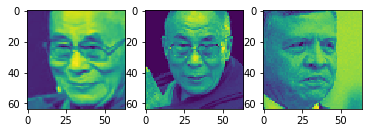

2th Triplets of 100:
Positive distance: 0.18912139534950256
Negative distance: 0.10584641247987747
Prediction: 0.48:


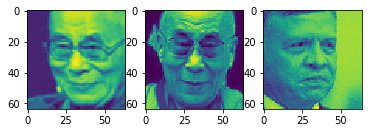

3th Triplets of 100:
Positive distance: 0.2072850465774536
Negative distance: 0.10584641247987747
Prediction: 0.50:


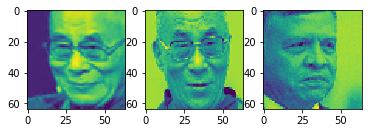

4th Triplets of 100:
Positive distance: 0.1815047562122345
Negative distance: 0.10584641247987747
Prediction: 0.48:


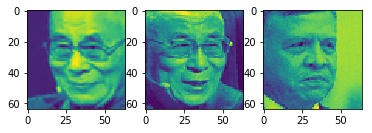

5th Triplets of 100:
Positive distance: 0.27692270278930664
Negative distance: 0.337810754776001
Prediction: 0.34:


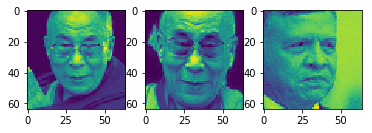

6th Triplets of 100:
Positive distance: 0.39434266090393066
Negative distance: 0.337810754776001
Prediction: 0.46:


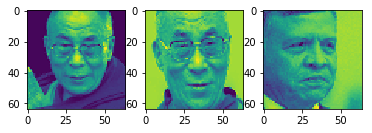

7th Triplets of 100:
Positive distance: 0.22056816518306732
Negative distance: 0.337810754776001
Prediction: 0.28:


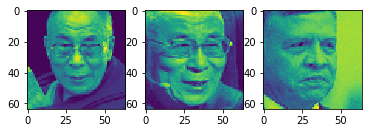

8th Triplets of 100:
Positive distance: 0.2840636968612671
Negative distance: 0.24755558371543884
Prediction: 0.44:


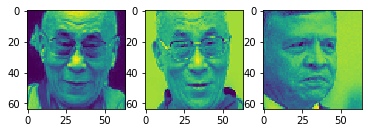

9th Triplets of 100:
Positive distance: 0.19572919607162476
Negative distance: 0.24755558371543884
Prediction: 0.35:


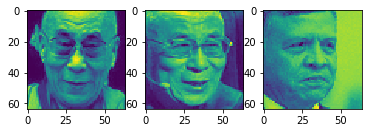

10th Triplets of 100:
Positive distance: 0.2523620128631592
Negative distance: 0.1341795176267624
Prediction: 0.52:


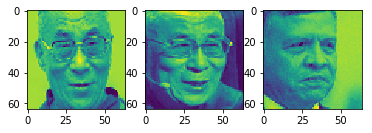

11th Triplets of 100:
Positive distance: 0.031369373202323914
Negative distance: 0.10584641247987747
Prediction: 0.33:


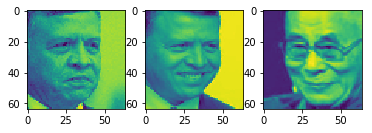

12th Triplets of 100:
Positive distance: 0.06102251634001732
Negative distance: 0.10584641247987747
Prediction: 0.36:


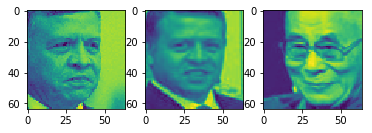

13th Triplets of 100:
Positive distance: 0.13431113958358765
Negative distance: 0.10584641247987747
Prediction: 0.43:


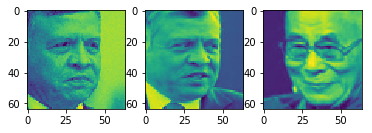

14th Triplets of 100:
Positive distance: 0.06080908328294754
Negative distance: 0.10584641247987747
Prediction: 0.35:


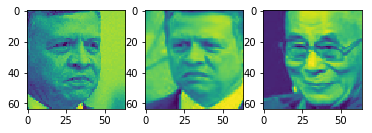

15th Triplets of 100:
Positive distance: 0.06710121035575867
Negative distance: 0.14884045720100403
Prediction: 0.32:


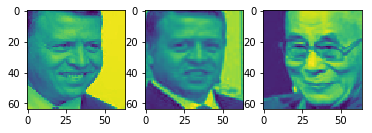

16th Triplets of 100:
Positive distance: 0.165959894657135
Negative distance: 0.14884045720100403
Prediction: 0.42:


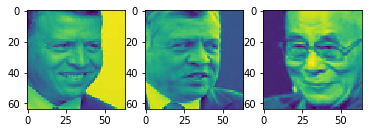

17th Triplets of 100:
Positive distance: 0.06038627028465271
Negative distance: 0.14884045720100403
Prediction: 0.31:


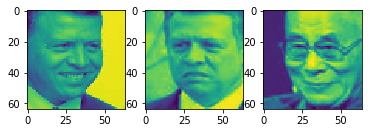

18th Triplets of 100:
Positive distance: 0.202485129237175
Negative distance: 0.14910830557346344
Prediction: 0.45:


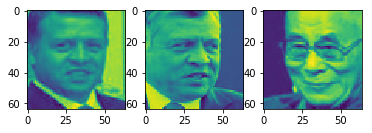

19th Triplets of 100:
Positive distance: 0.076727494597435
Negative distance: 0.14910830557346344
Prediction: 0.33:


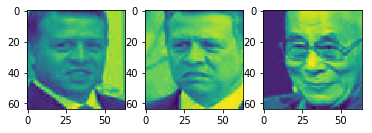

20th Triplets of 100:
Positive distance: 0.12568436563014984
Negative distance: 0.20648637413978577
Prediction: 0.32:


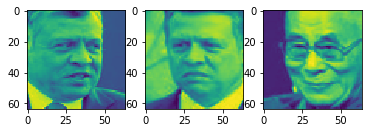

21th Triplets of 100:
Positive distance: 0.11058344691991806
Negative distance: 0.12705236673355103
Prediction: 0.38:


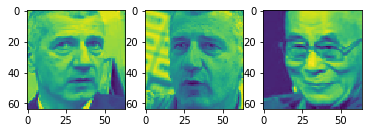

22th Triplets of 100:
Positive distance: 0.1133372113108635
Negative distance: 0.12705236673355103
Prediction: 0.39:


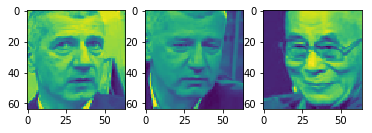

23th Triplets of 100:
Positive distance: 0.16314667463302612
Negative distance: 0.12705236673355103
Prediction: 0.44:


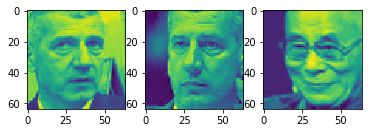

24th Triplets of 100:
Positive distance: 0.08147962391376495
Negative distance: 0.12705236673355103
Prediction: 0.35:


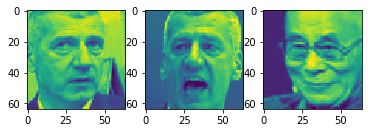

25th Triplets of 100:
Positive distance: 0.1549960970878601
Negative distance: 0.21969836950302124
Prediction: 0.34:


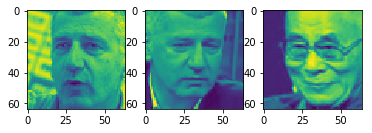

26th Triplets of 100:
Positive distance: 0.24464017152786255
Negative distance: 0.21969836950302124
Prediction: 0.42:


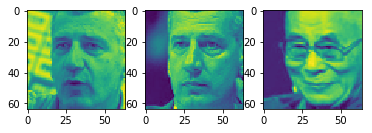

27th Triplets of 100:
Positive distance: 0.10767573863267899
Negative distance: 0.21969836950302124
Prediction: 0.29:


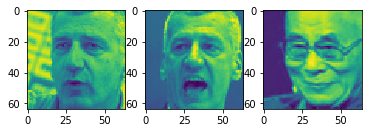

28th Triplets of 100:
Positive distance: 0.20423193275928497
Negative distance: 0.23582713305950165
Prediction: 0.37:


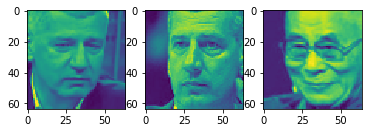

29th Triplets of 100:
Positive distance: 0.20718656480312347
Negative distance: 0.23582713305950165
Prediction: 0.37:


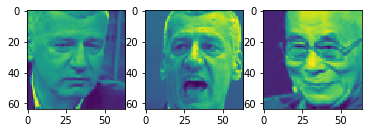

30th Triplets of 100:
Positive distance: 0.15204814076423645
Negative distance: 0.09771941602230072
Prediction: 0.45:


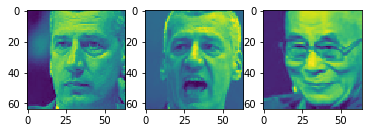

31th Triplets of 100:
Positive distance: 0.22171607613563538
Negative distance: 0.14248797297477722
Prediction: 0.48:


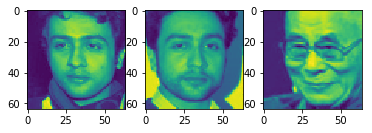

32th Triplets of 100:
Positive distance: 0.15953770279884338
Negative distance: 0.14248797297477722
Prediction: 0.42:


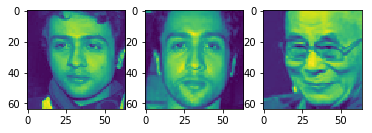

33th Triplets of 100:
Positive distance: 0.04079403355717659
Negative distance: 0.14248797297477722
Prediction: 0.30:


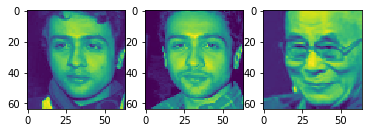

34th Triplets of 100:
Positive distance: 0.20741041004657745
Negative distance: 0.14248797297477722
Prediction: 0.46:


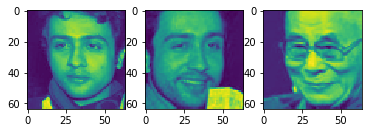

35th Triplets of 100:
Positive distance: 0.10548420250415802
Negative distance: 0.20329272747039795
Prediction: 0.30:


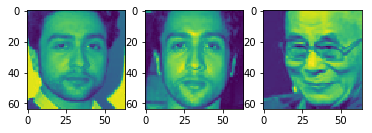

36th Triplets of 100:
Positive distance: 0.1806943714618683
Negative distance: 0.20329272747039795
Prediction: 0.38:


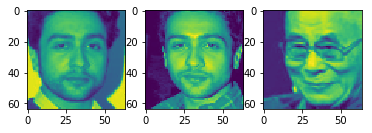

37th Triplets of 100:
Positive distance: 0.1312059760093689
Negative distance: 0.20329272747039795
Prediction: 0.33:


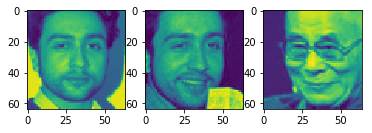

38th Triplets of 100:
Positive distance: 0.12826459109783173
Negative distance: 0.238203763961792
Prediction: 0.29:


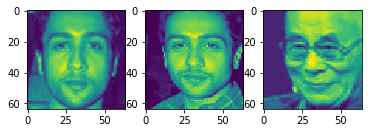

39th Triplets of 100:
Positive distance: 0.14615660905838013
Negative distance: 0.238203763961792
Prediction: 0.31:


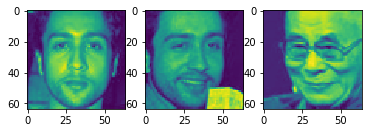

40th Triplets of 100:
Positive distance: 0.17391516268253326
Negative distance: 0.17031583189964294
Prediction: 0.40:


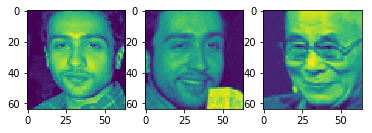

41th Triplets of 100:
Positive distance: 0.14898362755775452
Negative distance: 0.2573971748352051
Prediction: 0.29:


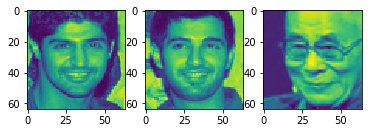

42th Triplets of 100:
Positive distance: 0.24270805716514587
Negative distance: 0.2573971748352051
Prediction: 0.39:


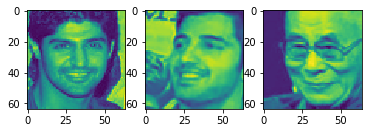

43th Triplets of 100:
Positive distance: 0.13796693086624146
Negative distance: 0.2573971748352051
Prediction: 0.28:


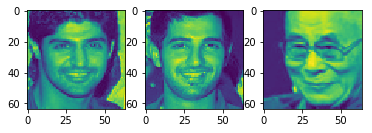

44th Triplets of 100:
Positive distance: 0.19133898615837097
Negative distance: 0.2573971748352051
Prediction: 0.33:


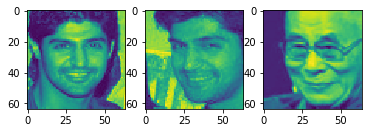

45th Triplets of 100:
Positive distance: 0.18440093100070953
Negative distance: 0.18494150042533875
Prediction: 0.40:


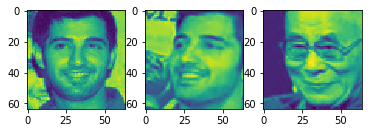

46th Triplets of 100:
Positive distance: 0.2066926211118698
Negative distance: 0.18494150042533875
Prediction: 0.42:


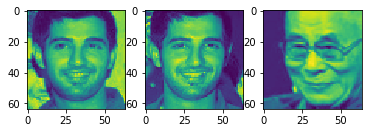

47th Triplets of 100:
Positive distance: 0.1682981252670288
Negative distance: 0.18494150042533875
Prediction: 0.38:


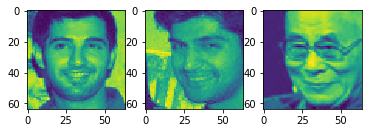

48th Triplets of 100:
Positive distance: 0.2316022515296936
Negative distance: 0.1615099459886551
Prediction: 0.47:


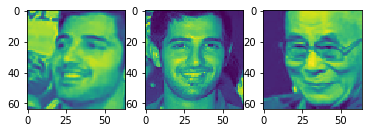

49th Triplets of 100:
Positive distance: 0.11701441556215286
Negative distance: 0.1615099459886551
Prediction: 0.36:


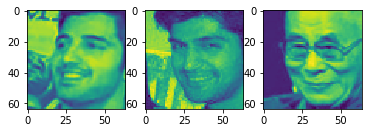

50th Triplets of 100:
Positive distance: 0.23449298739433289
Negative distance: 0.23807376623153687
Prediction: 0.40:


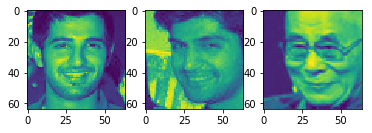

51th Triplets of 100:
Positive distance: 0.2607698440551758
Negative distance: 0.21168699860572815
Prediction: 0.45:


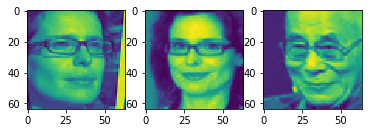

52th Triplets of 100:
Positive distance: 0.19471658766269684
Negative distance: 0.21168699860572815
Prediction: 0.38:


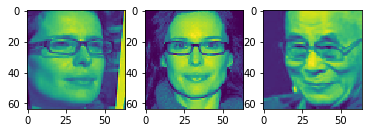

53th Triplets of 100:
Positive distance: 0.12431225180625916
Negative distance: 0.21168699860572815
Prediction: 0.31:


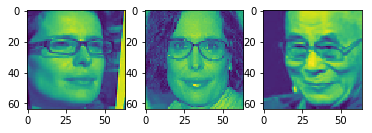

54th Triplets of 100:
Positive distance: 0.30367398262023926
Negative distance: 0.21168699860572815
Prediction: 0.49:


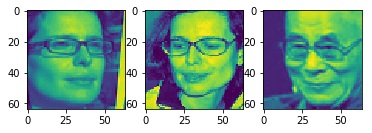

55th Triplets of 100:
Positive distance: 0.09145887941122055
Negative distance: 0.18858496844768524
Prediction: 0.30:


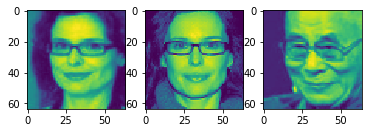

56th Triplets of 100:
Positive distance: 0.09790186583995819
Negative distance: 0.18858496844768524
Prediction: 0.31:


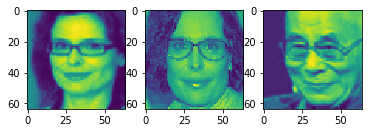

57th Triplets of 100:
Positive distance: 0.1134444922208786
Negative distance: 0.18858496844768524
Prediction: 0.32:


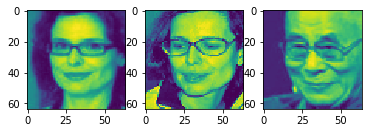

58th Triplets of 100:
Positive distance: 0.10469546914100647
Negative distance: 0.2321687638759613
Prediction: 0.27:


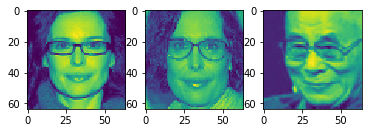

59th Triplets of 100:
Positive distance: 0.14920280873775482
Negative distance: 0.2321687638759613
Prediction: 0.32:


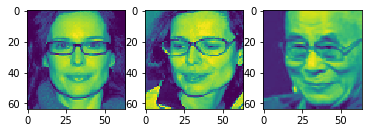

60th Triplets of 100:
Positive distance: 0.15776020288467407
Negative distance: 0.13081470131874084
Prediction: 0.43:


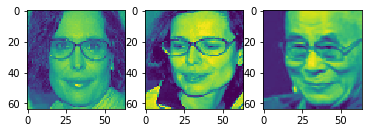

61th Triplets of 100:
Positive distance: 0.18777605891227722
Negative distance: 0.21990914642810822
Prediction: 0.37:


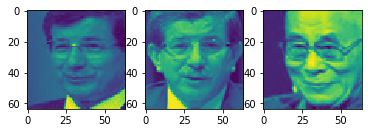

62th Triplets of 100:
Positive distance: 0.13340641558170319
Negative distance: 0.21990914642810822
Prediction: 0.31:


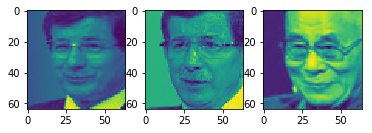

63th Triplets of 100:
Positive distance: 0.07577525079250336
Negative distance: 0.21990914642810822
Prediction: 0.26:


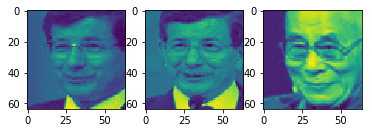

64th Triplets of 100:
Positive distance: 0.107305146753788
Negative distance: 0.21990914642810822
Prediction: 0.29:


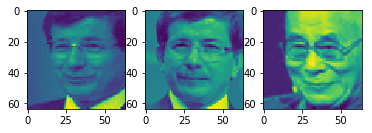

65th Triplets of 100:
Positive distance: 0.2200135588645935
Negative distance: 0.2208670973777771
Prediction: 0.40:


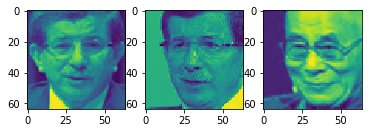

66th Triplets of 100:
Positive distance: 0.19095765054225922
Negative distance: 0.2208670973777771
Prediction: 0.37:


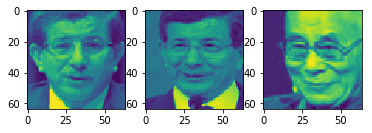

67th Triplets of 100:
Positive distance: 0.19230271875858307
Negative distance: 0.2208670973777771
Prediction: 0.37:


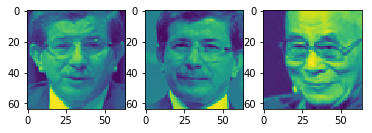

68th Triplets of 100:
Positive distance: 0.11356067657470703
Negative distance: 0.17688395082950592
Prediction: 0.34:


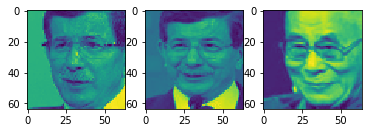

69th Triplets of 100:
Positive distance: 0.13605688512325287
Negative distance: 0.17688395082950592
Prediction: 0.36:


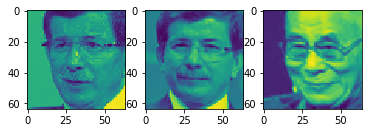

70th Triplets of 100:
Positive distance: 0.07368756085634232
Negative distance: 0.1417846381664276
Prediction: 0.33:


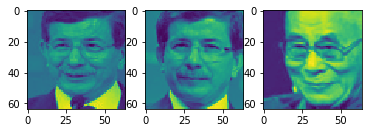

71th Triplets of 100:
Positive distance: 0.3013220429420471
Negative distance: 0.46944040060043335
Prediction: 0.23:


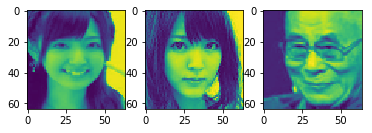

72th Triplets of 100:
Positive distance: 0.35791730880737305
Negative distance: 0.46944040060043335
Prediction: 0.29:


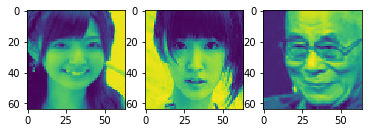

73th Triplets of 100:
Positive distance: 0.3867916166782379
Negative distance: 0.46944040060043335
Prediction: 0.32:


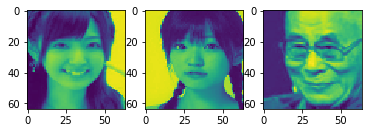

74th Triplets of 100:
Positive distance: 0.24424104392528534
Negative distance: 0.46944040060043335
Prediction: 0.17:


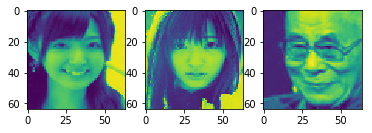

75th Triplets of 100:
Positive distance: 0.2972644567489624
Negative distance: 0.44103801250457764
Prediction: 0.26:


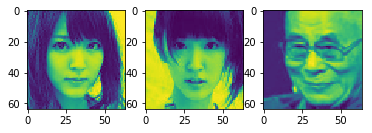

76th Triplets of 100:
Positive distance: 0.4009989798069
Negative distance: 0.44103801250457764
Prediction: 0.36:


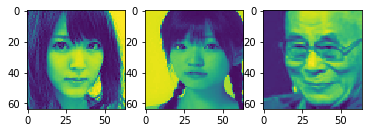

77th Triplets of 100:
Positive distance: 0.23817315697669983
Negative distance: 0.44103801250457764
Prediction: 0.20:


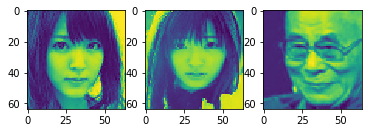

78th Triplets of 100:
Positive distance: 0.13240385055541992
Negative distance: 0.44312784075737
Prediction: 0.09:


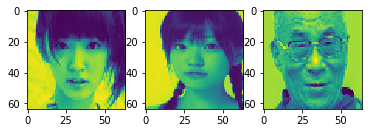

79th Triplets of 100:
Positive distance: 0.27599722146987915
Negative distance: 0.5413453578948975
Prediction: 0.13:


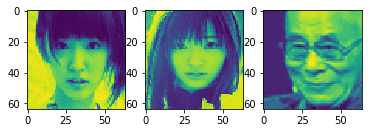

80th Triplets of 100:
Positive distance: 0.31703677773475647
Negative distance: 0.6083706617355347
Prediction: 0.11:


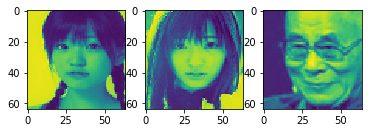

81th Triplets of 100:
Positive distance: 0.25190985202789307
Negative distance: 0.20340415835380554
Prediction: 0.45:


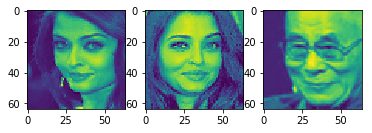

82th Triplets of 100:
Positive distance: 0.2066114842891693
Negative distance: 0.20340415835380554
Prediction: 0.40:


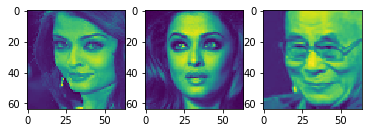

83th Triplets of 100:
Positive distance: 0.19631163775920868
Negative distance: 0.20340415835380554
Prediction: 0.39:


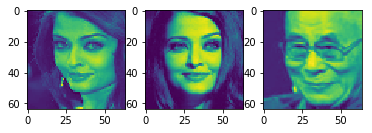

84th Triplets of 100:
Positive distance: 0.21716707944869995
Negative distance: 0.20340415835380554
Prediction: 0.41:


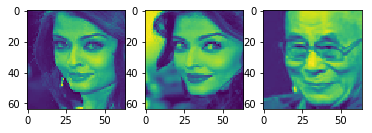

85th Triplets of 100:
Positive distance: 0.1753157675266266
Negative distance: 0.23199264705181122
Prediction: 0.34:


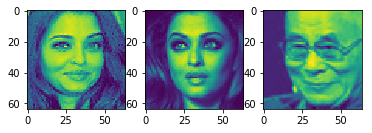

86th Triplets of 100:
Positive distance: 0.17115575075149536
Negative distance: 0.23199264705181122
Prediction: 0.34:


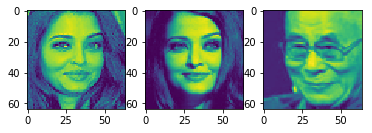

87th Triplets of 100:
Positive distance: 0.2689375877380371
Negative distance: 0.23199264705181122
Prediction: 0.44:


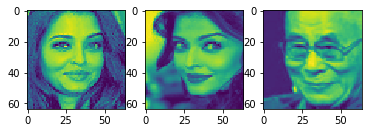

88th Triplets of 100:
Positive distance: 0.11716856062412262
Negative distance: 0.3146100640296936
Prediction: 0.20:


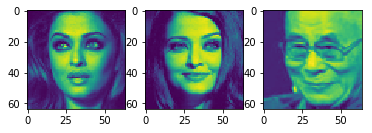

89th Triplets of 100:
Positive distance: 0.32236248254776
Negative distance: 0.3146100640296936
Prediction: 0.41:


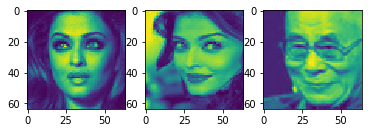

90th Triplets of 100:
Positive distance: 0.3038914203643799
Negative distance: 0.29603826999664307
Prediction: 0.41:


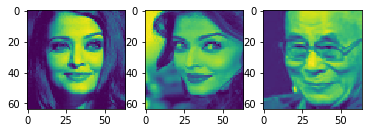

91th Triplets of 100:
Positive distance: 0.05930788815021515
Negative distance: 0.21038436889648438
Prediction: 0.25:


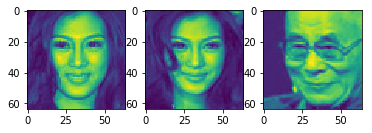

92th Triplets of 100:
Positive distance: 0.08248618990182877
Negative distance: 0.21038436889648438
Prediction: 0.27:


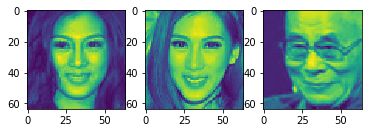

93th Triplets of 100:
Positive distance: 0.0999184399843216
Negative distance: 0.21038436889648438
Prediction: 0.29:


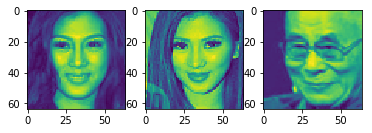

94th Triplets of 100:
Positive distance: 0.21715210378170013
Negative distance: 0.21038436889648438
Prediction: 0.41:


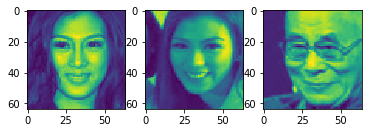

95th Triplets of 100:
Positive distance: 0.1597137749195099
Negative distance: 0.27628642320632935
Prediction: 0.28:


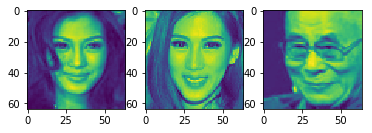

96th Triplets of 100:
Positive distance: 0.16675397753715515
Negative distance: 0.27628642320632935
Prediction: 0.29:


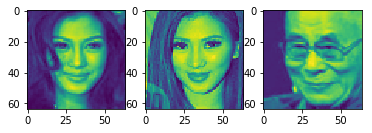

97th Triplets of 100:
Positive distance: 0.3008183240890503
Negative distance: 0.27628642320632935
Prediction: 0.42:


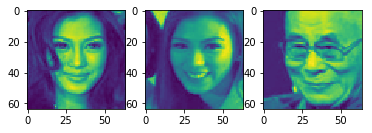

98th Triplets of 100:
Positive distance: 0.10832918435335159
Negative distance: 0.1632230281829834
Prediction: 0.35:


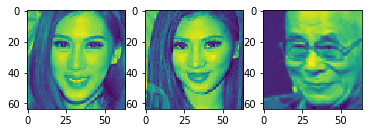

99th Triplets of 100:
Positive distance: 0.17788581550121307
Negative distance: 0.1632230281829834
Prediction: 0.41:


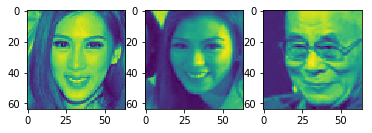

100th Triplets of 100:
Positive distance: 0.13544413447380066
Negative distance: 0.15208712220191956
Prediction: 0.38:


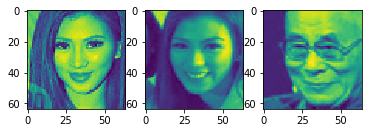

In [14]:
# we use matplotlib to display the images
import matplotlib.pyplot as plt
%matplotlib inline

# creating an instance of the generator
generator = triplet_generator(model,X_train_batch)
i = 0
for batch in generator:
    print("SHAPE OF THE BATCH: {}".format(batch[0][2].shape))
    for tri in range(len(batch[1])):
        anch = np.expand_dims(batch[0][0][tri,...], axis=0)
        pos = np.expand_dims(batch[0][1][tri,...], axis=0)
        neg = np.expand_dims(batch[0][2][tri,...], axis=0)
        print("{}th Triplets of {}:".format(tri+1,len(batch[1])))
        # creating predictions
        preds = model.predict([anch,pos,neg])[0]
        anch_pred = preds[:128]
        pos_pred = preds[128:256]
        neg_pred = preds[256:]
        print("Positive distance: {}".format(np.sum(np.square(anch_pred-pos_pred))))
        print("Negative distance: {}".format(np.sum(np.square(anch_pred-neg_pred))))
        loss = tripletloss(anch_pred,pos_pred,neg_pred)
        print("Prediction: %.2f:"%(loss))
        f, axarr = plt.subplots(1,3)
        axarr[0].imshow(anch[0][:,:,0])
        axarr[1].imshow(pos[0][:,:,0])
        axarr[2].imshow(neg[0][:,:,0])
        plt.show()
    i = i+1
    if i > 0:
        break

Training the model with the generators.

In [15]:
train_generator = triplet_generator(model, X_train_batch)
valid_generator = triplet_generator(model, X_valid_batch, for_training = False)
history = model.fit_generator(
      train_generator,
      steps_per_epoch=1,
      epochs=100,
      validation_data=valid_generator,
      validation_steps = 1,
      verbose=1)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.3547 - val_loss: 0.3188
Epoch 2/100
1/1 [==============================] - 1s 520ms/step - loss: 0.3285 - val_loss: 0.4296
Epoch 3/100
1/1 [==============================] - 1s 554ms/step - loss: 0.3510 - val_loss: 0.4065
Epoch 4/100
1/1 [==============================] - 1s 516ms/step - loss: 0.3577 - val_loss: 0.3251
Epoch 5/100
1/1 [==============================] - 1s 579ms/step - loss: 0.3591 - val_loss: 0.3520
Epoch 6/100
1/1 [==============================] - 1s 533ms/step - loss: 0.3216 - val_loss: 0.3022
Epoch 7/100
1/1 [==============================] - 1s 564ms/step - loss: 0.4221 - val_loss: 0.4020
Epoch 8/100
1/1 [==============================] - 1s 556ms/step - loss: 0.2876 - val_loss: 0.3600
Epoch 9/100
1/1 [==============================] - 1s 563ms/step - loss: 0.3509 - val_loss: 0.4205
Epoch 10/100
1/1 [==============================] - 1s 543ms/step - loss: 0.2756 - val_loss: 0.0954
Epoch 11/100

Epoch 84/100
1/1 [==============================] - 1s 566ms/step - loss: 0.4765 - val_loss: 0.1790
Epoch 85/100
1/1 [==============================] - 1s 547ms/step - loss: 0.3319 - val_loss: 0.1205
Epoch 86/100
1/1 [==============================] - 1s 554ms/step - loss: 0.2827 - val_loss: 0.2223
Epoch 87/100
1/1 [==============================] - 1s 559ms/step - loss: 0.2604 - val_loss: 0.2770
Epoch 88/100
1/1 [==============================] - 1s 547ms/step - loss: 0.2080 - val_loss: 0.1167
Epoch 89/100
1/1 [==============================] - 1s 561ms/step - loss: 0.2903 - val_loss: 0.2860
Epoch 90/100
1/1 [==============================] - 1s 552ms/step - loss: 0.2871 - val_loss: 0.4692
Epoch 91/100
1/1 [==============================] - 1s 560ms/step - loss: 0.2902 - val_loss: 0.2892
Epoch 92/100
1/1 [==============================] - 1s 555ms/step - loss: 0.2332 - val_loss: 0.2129
Epoch 93/100
1/1 [==============================] - 1s 560ms/step - loss: 0.2334 - val_loss: 0.2081


Text(0.5,1,'Training and validation loss')

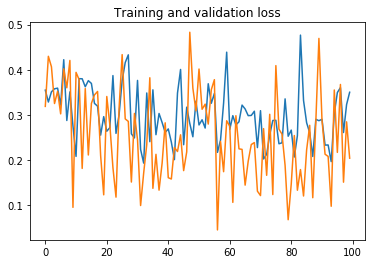

In [16]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(loss))

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

Displaying the first batch of triplets generated with validation generator to check the changes.

SHAPE OF THE BATCH: (100, 64, 64, 1)
1th Triplets of 100:
1.3971736
0.5303465
Prediction: 1.27:


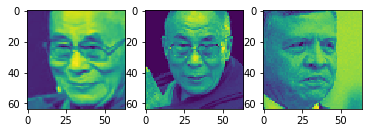

2th Triplets of 100:
0.75169134
0.5303465
Prediction: 0.62:


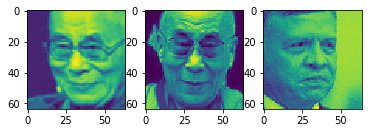

3th Triplets of 100:
0.6457666
0.5303465
Prediction: 0.52:


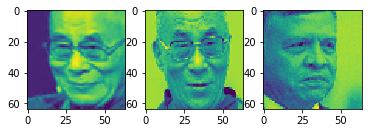

4th Triplets of 100:
0.9698765
0.5303465
Prediction: 0.84:


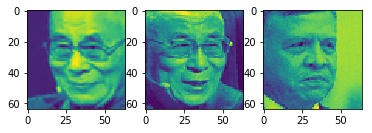

5th Triplets of 100:
1.326794
1.6119809
Prediction: 0.11:


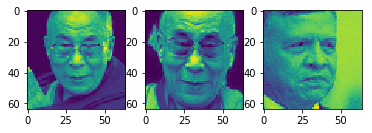

6th Triplets of 100:
1.528959
1.6119809
Prediction: 0.32:


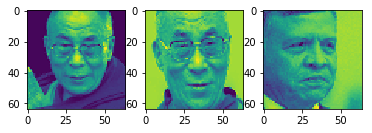

7th Triplets of 100:
1.3234353
1.6119809
Prediction: 0.11:


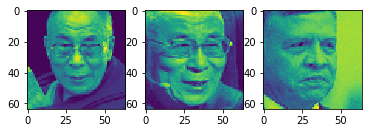

8th Triplets of 100:
0.9362351
0.84782875
Prediction: 0.49:


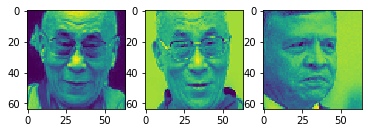

9th Triplets of 100:
1.269299
0.84782875
Prediction: 0.82:


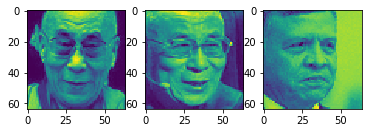

10th Triplets of 100:
1.1420784
0.51386285
Prediction: 1.03:


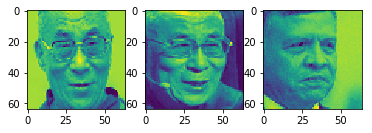

11th Triplets of 100:
0.20438702
0.5303465
Prediction: 0.07:


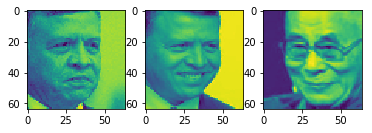

12th Triplets of 100:
0.28611514
0.5303465
Prediction: 0.16:


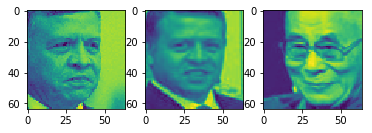

13th Triplets of 100:
0.58283126
0.5303465
Prediction: 0.45:


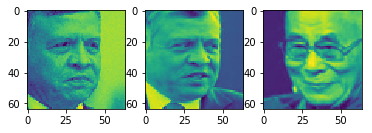

14th Triplets of 100:
0.19372356
0.5303465
Prediction: 0.06:


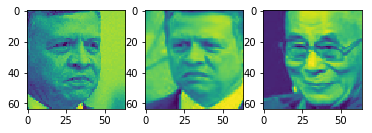

15th Triplets of 100:
0.2723403
0.73944473
Prediction: 0.00:


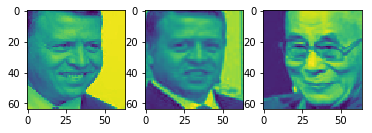

16th Triplets of 100:
0.6164966
0.73944473
Prediction: 0.28:


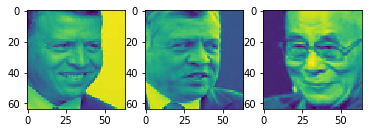

17th Triplets of 100:
0.21281485
0.73944473
Prediction: 0.00:


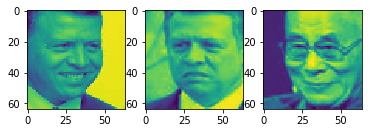

18th Triplets of 100:
0.8350092
0.57713914
Prediction: 0.66:


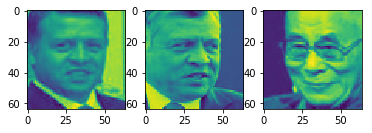

19th Triplets of 100:
0.252634
0.57713914
Prediction: 0.08:


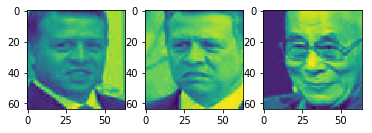

20th Triplets of 100:
0.67004824
0.90696174
Prediction: 0.16:


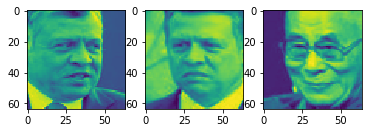

21th Triplets of 100:
0.4247923
0.6596447
Prediction: 0.17:


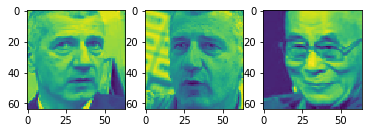

22th Triplets of 100:
0.40218416
0.6596447
Prediction: 0.14:


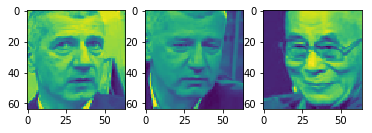

23th Triplets of 100:
0.6856116
0.6596447
Prediction: 0.43:


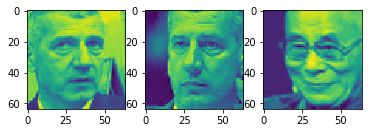

24th Triplets of 100:
0.39434078
0.6596447
Prediction: 0.13:


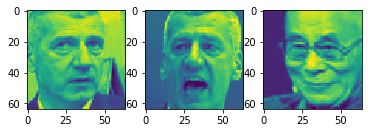

25th Triplets of 100:
0.52704656
0.6568624
Prediction: 0.27:


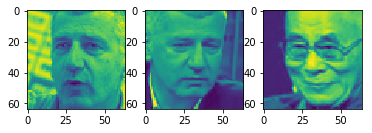

26th Triplets of 100:
0.7411801
0.6568624
Prediction: 0.48:


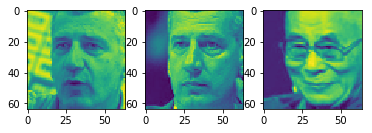

27th Triplets of 100:
0.32160893
0.6568624
Prediction: 0.06:


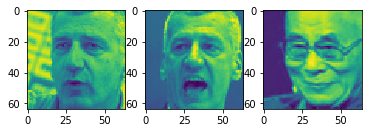

28th Triplets of 100:
0.72936463
0.68161726
Prediction: 0.45:


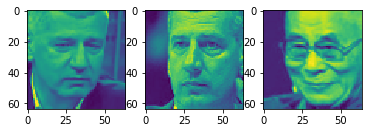

29th Triplets of 100:
0.6902491
0.68161726
Prediction: 0.41:


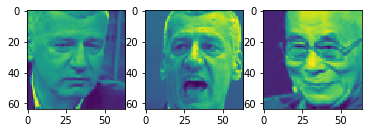

30th Triplets of 100:
0.61284804
0.5325946
Prediction: 0.48:


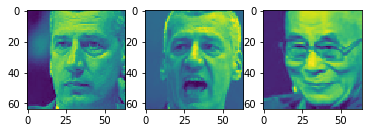

31th Triplets of 100:
1.2361078
1.4536777
Prediction: 0.18:


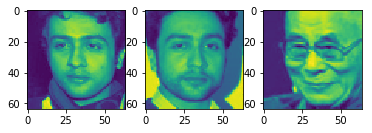

32th Triplets of 100:
1.2192523
1.4536777
Prediction: 0.17:


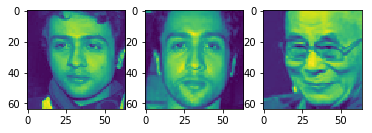

33th Triplets of 100:
0.5394284
1.4536777
Prediction: 0.00:


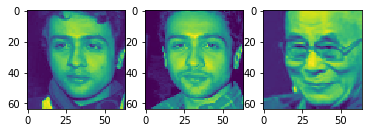

34th Triplets of 100:
1.2098472
1.4536777
Prediction: 0.16:


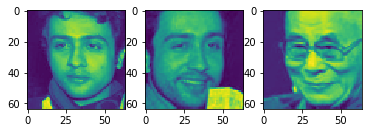

35th Triplets of 100:
0.59476435
1.1386371
Prediction: 0.00:


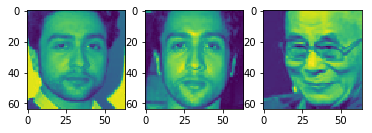

36th Triplets of 100:
0.6830312
1.1386371
Prediction: 0.00:


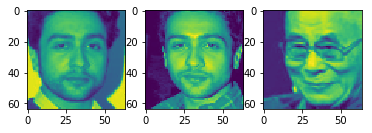

37th Triplets of 100:
0.8820753
1.1386371
Prediction: 0.14:


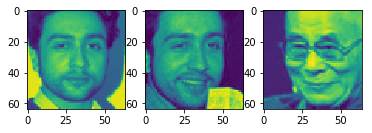

38th Triplets of 100:
0.6776273
1.4455705
Prediction: 0.00:


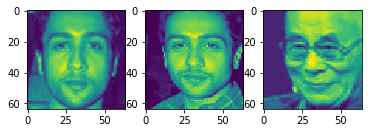

39th Triplets of 100:
1.1471877
1.4455705
Prediction: 0.10:


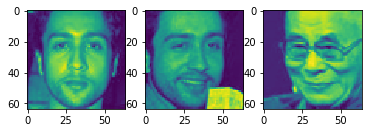

40th Triplets of 100:
1.01847
1.2712221
Prediction: 0.15:


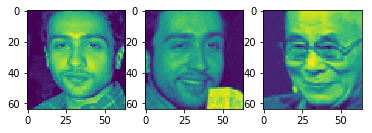

41th Triplets of 100:
0.6713338
1.5959475
Prediction: 0.00:


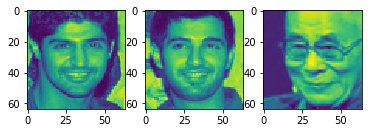

42th Triplets of 100:
1.5410994
1.5959475
Prediction: 0.35:


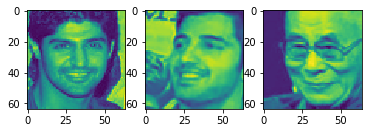

43th Triplets of 100:
0.58396995
1.5959475
Prediction: 0.00:


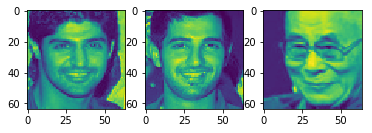

44th Triplets of 100:
1.0376163
1.5959475
Prediction: 0.00:


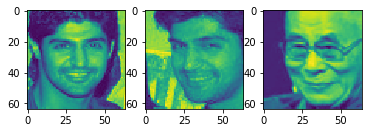

45th Triplets of 100:
1.193308
1.2270225
Prediction: 0.37:


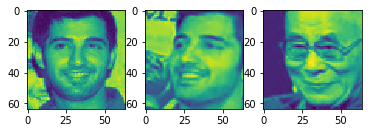

46th Triplets of 100:
0.74784863
1.2270225
Prediction: 0.00:


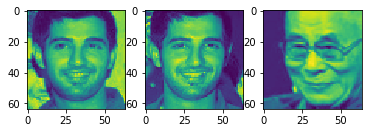

47th Triplets of 100:
0.8518616
1.2270225
Prediction: 0.02:


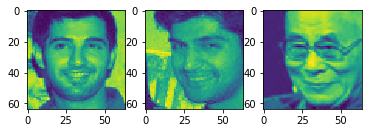

48th Triplets of 100:
1.434352
0.68804437
Prediction: 1.15:


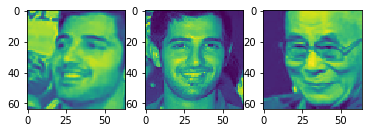

49th Triplets of 100:
0.57951504
0.68804437
Prediction: 0.29:


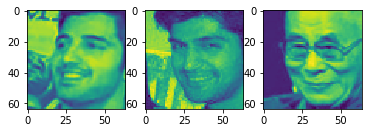

50th Triplets of 100:
1.2071383
1.3594042
Prediction: 0.25:


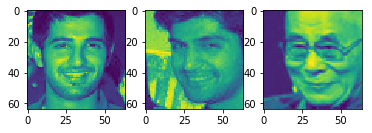

51th Triplets of 100:
1.0588074
0.88949496
Prediction: 0.57:


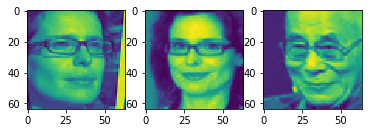

52th Triplets of 100:
0.9285853
0.88949496
Prediction: 0.44:


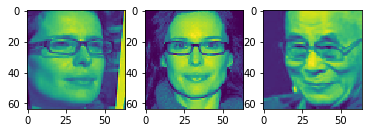

53th Triplets of 100:
0.6296191
0.88949496
Prediction: 0.14:


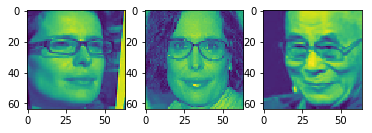

54th Triplets of 100:
1.2335036
0.88949496
Prediction: 0.74:


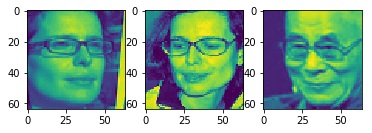

55th Triplets of 100:
0.29124156
1.3188646
Prediction: 0.00:


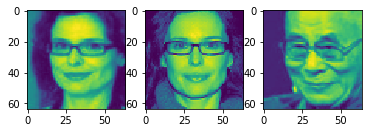

56th Triplets of 100:
0.348871
1.3188646
Prediction: 0.00:


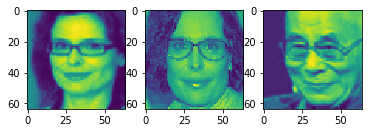

57th Triplets of 100:
0.53557813
1.3188646
Prediction: 0.00:


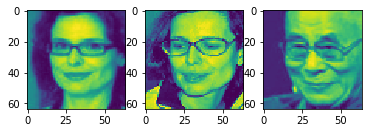

58th Triplets of 100:
0.31948814
1.2821069
Prediction: 0.00:


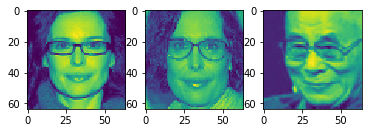

59th Triplets of 100:
0.6409291
1.2821069
Prediction: 0.00:


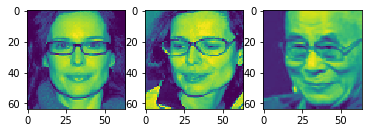

60th Triplets of 100:
0.80911374
1.1534457
Prediction: 0.06:


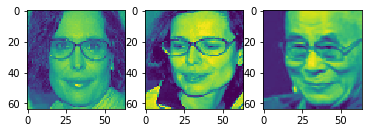

61th Triplets of 100:
0.8565495
1.4070199
Prediction: 0.00:


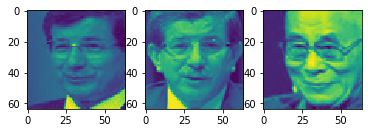

62th Triplets of 100:
0.7313458
1.4070199
Prediction: 0.00:


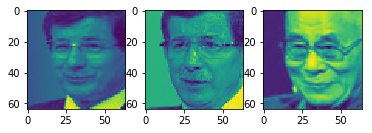

63th Triplets of 100:
0.5585644
1.4070199
Prediction: 0.00:


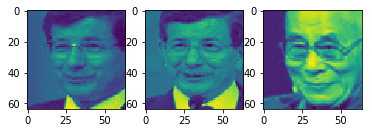

64th Triplets of 100:
0.44177034
1.4070199
Prediction: 0.00:


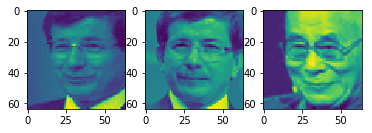

65th Triplets of 100:
1.0783875
1.1453462
Prediction: 0.33:


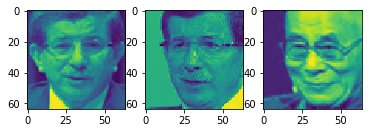

66th Triplets of 100:
1.0673244
1.1453462
Prediction: 0.32:


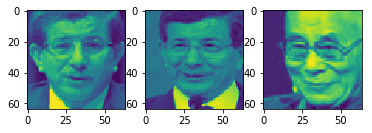

67th Triplets of 100:
1.0228975
1.1453462
Prediction: 0.28:


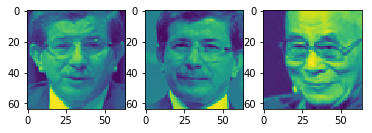

68th Triplets of 100:
0.66481125
0.80916774
Prediction: 0.26:


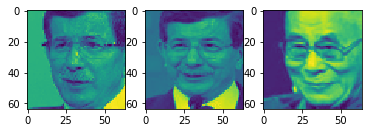

69th Triplets of 100:
0.80372345
0.80916774
Prediction: 0.39:


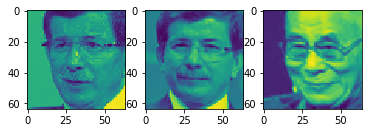

70th Triplets of 100:
0.4191896
1.0857153
Prediction: 0.00:


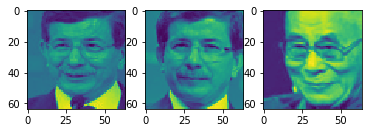

71th Triplets of 100:
0.48905337
1.2678463
Prediction: 0.00:


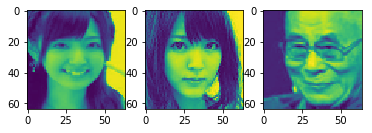

72th Triplets of 100:
0.5387649
1.2678463
Prediction: 0.00:


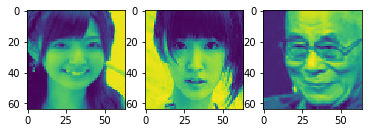

73th Triplets of 100:
0.5824657
1.2678463
Prediction: 0.00:


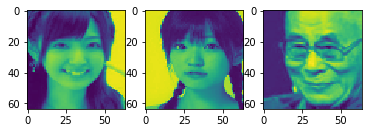

74th Triplets of 100:
0.4152215
1.2678463
Prediction: 0.00:


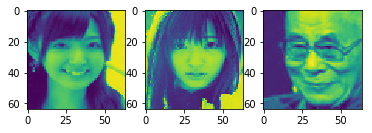

75th Triplets of 100:
0.5771408
1.2001051
Prediction: 0.00:


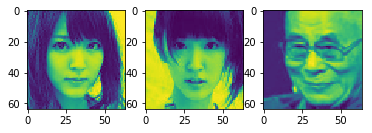

76th Triplets of 100:
0.6943759
1.2001051
Prediction: 0.00:


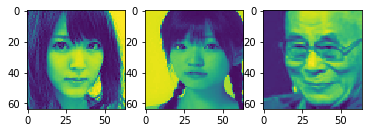

77th Triplets of 100:
0.5393307
1.2001051
Prediction: 0.00:


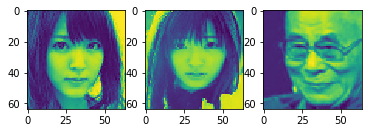

78th Triplets of 100:
0.29018125
1.4834065
Prediction: 0.00:


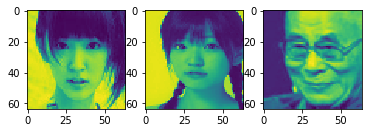

79th Triplets of 100:
0.77661467
1.4834065
Prediction: 0.00:


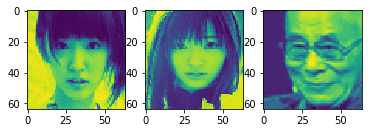

80th Triplets of 100:
0.67339694
1.4253587
Prediction: 0.00:


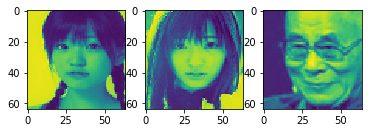

81th Triplets of 100:
0.75595903
1.2708265
Prediction: 0.00:


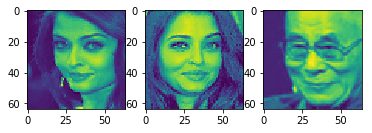

82th Triplets of 100:
0.6912711
1.2708265
Prediction: 0.00:


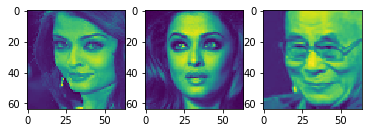

83th Triplets of 100:
0.42042595
1.2708265
Prediction: 0.00:


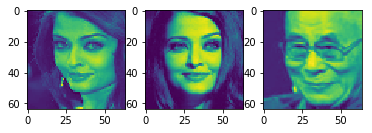

84th Triplets of 100:
0.6074406
1.2708265
Prediction: 0.00:


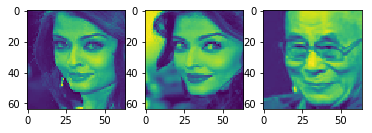

85th Triplets of 100:
0.51314425
1.1554441
Prediction: 0.00:


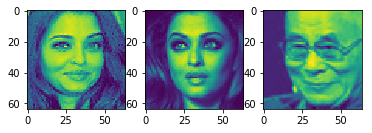

86th Triplets of 100:
0.4940832
1.1554441
Prediction: 0.00:


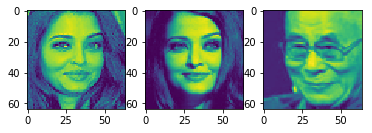

87th Triplets of 100:
1.0009218
1.1554441
Prediction: 0.25:


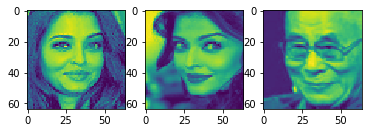

88th Triplets of 100:
0.49213368
1.4937277
Prediction: 0.00:


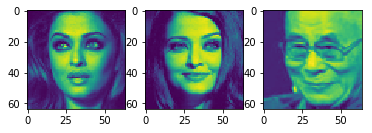

89th Triplets of 100:
0.867238
1.4937277
Prediction: 0.00:


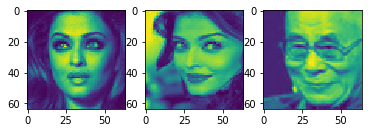

90th Triplets of 100:
0.9425807
1.3585814
Prediction: 0.00:


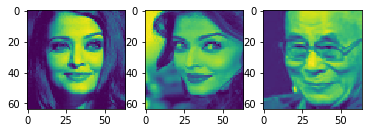

91th Triplets of 100:
0.24201554
1.3597126
Prediction: 0.00:


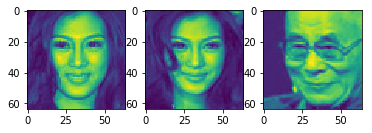

92th Triplets of 100:
0.37964755
1.3597126
Prediction: 0.00:


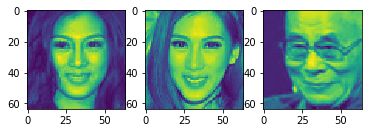

93th Triplets of 100:
0.53649986
1.3597126
Prediction: 0.00:


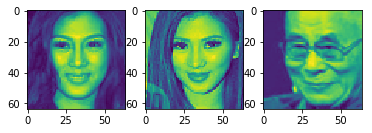

94th Triplets of 100:
1.2141206
1.3597126
Prediction: 0.25:


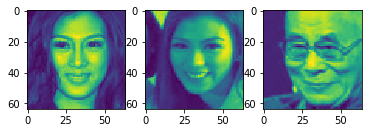

95th Triplets of 100:
0.6267253
1.3498714
Prediction: 0.00:


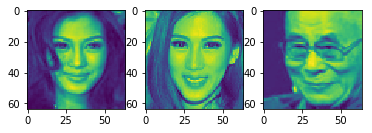

96th Triplets of 100:
0.55086714
1.3498714
Prediction: 0.00:


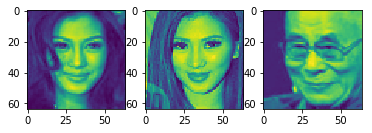

97th Triplets of 100:
1.3716413
1.3498714
Prediction: 0.42:


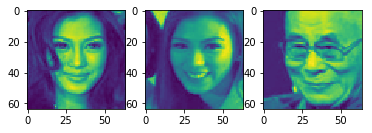

98th Triplets of 100:
0.72529364
1.0312719
Prediction: 0.09:


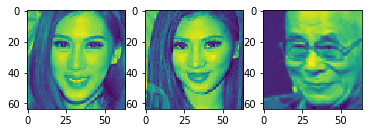

99th Triplets of 100:
0.97379875
1.0312719
Prediction: 0.34:


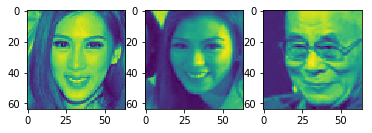

100th Triplets of 100:
0.9490264
1.2291447
Prediction: 0.12:


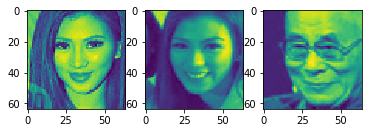

In [17]:
generator = triplet_generator(model,X_train_batch, for_training = False)
i = 0
for batch in generator:
    print("SHAPE OF THE BATCH: {}".format(batch[0][2].shape))
    for tri in range(len(batch[1])):
        anch = np.expand_dims(batch[0][0][tri,...], axis=0)
        pos = np.expand_dims(batch[0][1][tri,...], axis=0)
        neg = np.expand_dims(batch[0][2][tri,...], axis=0)
        print("{}th Triplets of {}:".format(tri+1,len(batch[1])))
        preds = model.predict([anch,pos,neg])[0]
        anch_pred = preds[:128]
        pos_pred = preds[128:256]
        neg_pred = preds[256:]
        print(np.sum(np.square(anch_pred-pos_pred)))
        print(np.sum(np.square(anch_pred-neg_pred)))
        loss = tripletloss(anch_pred,pos_pred,neg_pred)
        print("Prediction: %.2f:"%(loss))
        f, axarr = plt.subplots(1,3)
        axarr[0].imshow(anch[0][:,:,0])
        axarr[1].imshow(pos[0][:,:,0])
        axarr[2].imshow(neg[0][:,:,0])
        plt.show()
    i = i+1
    if i > 0:
        break

The function below is used to test the network on the test values.

In [18]:
def model_test(network, X_test, threshold):
    same_pair = 0
    for i in range(0,len(X_test)-1,2):
        img1 = np.expand_dims(X_test[i], axis=0)
        img1 = np.expand_dims(img1, axis=3)
        img2 = np.expand_dims(X_test[i+1], axis=0)
        img2 = np.expand_dims(img2, axis=3)
        preds = network.predict([img1,img2,img1])[0]
        pred1 = preds[:128]
        pred2 = preds[128:256]
        dist = np.sum(np.square(pred1-pred2))
        if(dist<threshold):
            same_pair += 1
    return same_pair
    

In [19]:
# calculating the difference between the number of positive and negative distances that are below the threshold
difference = []
for i in range(0,100,10):
    difference.append(model_test(model,X_test_positives,i/100.0)-model_test(model,X_test_negatives,i/100.0))

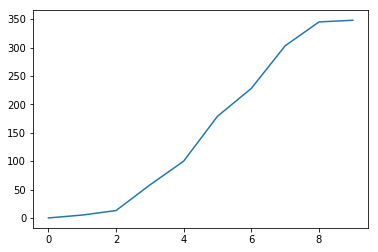

In [20]:
plt.plot(difference)
plt.show()